# Modélisation de la variable énergie

**Rappel de l'objectif**

L'objectif de ce projet est de prédire les émissions de CO₂ ainsi que la consommation totale d'énergie des bâtiments non résidentiels de la ville de Seattle à partir de leurs caractéristiques structurelles (surface, usage, année de construction, localisation, etc.).  
Cette démarche s’inscrit dans l’objectif global de neutralité carbone fixé par la ville à l’horizon 2050.

**Contexte du notebook**

Dans ce notebook, nous allons préparer les données, entraîner des modèles et analyser les résultats liés à la prédiction de la consommation d'énergie.

Le jeu de données a été préalablement nettoyé et préparé dans le fichier `notebook_1.ipynb`.



## Sommaire

1. **Préparation des features pour la modélisation**
2. **Optimisation des hyperparamètres (GridSearchCV)**
3. **Évaluation avec le jeu de données de validation**
4. **Analyse de l'impact de ENERGYSTARScore**
5. **Conclusion et recommandations**

## Préparation des features pour la modélisation
### Configuration du notebook

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import time
import seaborn as sns

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
	KFold
)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance
from sklearn.base import clone

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid")

# Constantes
TARGET_CO2 = 'GHGEmissionsIntensity'
TARGET_ENERGY = 'SiteEUIWN(kBtu/sf)'
CIBLES = [TARGET_ENERGY, TARGET_CO2]

TEST_SIZE = 0.2
RANDOM_STATE = 42
N_SPLITS = 5 # Choix standard pour la validation croisée


# Chargement des données
df_origin = pd.read_csv('data/data_train_test_clean.csv')

df = df_origin.copy()

print("📊 Dataset chargé")
print(f"   Shape : {df.shape}")
print(f"   Lignes : {len(df):,} bâtiments")
print(f"   Colonnes : {df.shape[1]}")
df.info()


📊 Dataset chargé
   Shape : (1151, 28)
   Lignes : 1,151 bâtiments
   Colonnes : 28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1151 non-null   object 
 1   PrimaryPropertyType              1151 non-null   object 
 2   Neighborhood                     1151 non-null   object 
 3   NumberofBuildings                1151 non-null   int64  
 4   NumberofFloors                   1151 non-null   int64  
 5   ENERGYSTARScore                  744 non-null    float64
 6   SiteEUIWN(kBtu/sf)               1151 non-null   float64
 7   GHGEmissionsIntensity            1151 non-null   float64
 8   num_years_certified              1151 non-null   int64  
 9   num_property_uses                1151 non-null   int64  
 10  use_type_gfa_residual            1151 non-null   float64
 11

### Composition de X et y

`X` regroupe l’ensemble des features, à l’exception de `ENERGYSTARScore`, ainsi que les deux variables cibles.  
Nous testerons dans un second temps l’ajout de `ENERGYSTARScore` afin d’évaluer son impact sur les performances du modèle.

`y` correspond à la variable cible `SiteEUIWN(kBtu/sf)`.  
La variable `GHGEmissionsIntensity` sera quant à elle modélisée et analysée dans un autre notebook.

In [ ]:
def split_features_targets(df: pd.DataFrame, columns_to_drop: List[str], target: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Sépare les features et la variable cible.
    
    Parameters
    ----------
    df : DataFrame contenant toutes les colonnes
    columns_to_drop : colonnes à exclure des features
    target : nom de la variable cible
    
    Returns
    -------
    X : DataFrame des features
    y : Series de la variable cible
    """
    X = df.drop(columns=columns_to_drop)
    y = df[target]
    return X, y

X, y = split_features_targets(df, CIBLES + ['ENERGYSTARScore'], TARGET_ENERGY)

assert X.isna().sum().sum() == 0, "Valeurs manquantes détectées dans X"
assert y.isna().sum() == 0, "Valeurs manquantes détectées dans y"

print(f"X : {X.shape}")
print(f"y : {y.shape}")



X : (1151, 25)
y : (1151,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1151 non-null   object 
 1   PrimaryPropertyType              1151 non-null   object 
 2   Neighborhood                     1151 non-null   object 
 3   NumberofBuildings                1151 non-null   int64  
 4   NumberofFloors                   1151 non-null   int64  
 5   num_years_certified              1151 non-null   int64  
 6   num_property_uses                1151 non-null   int64  
 7   use_type_gfa_residual            1151 non-null   float64
 8   gfa_filled_zero                  1151 non-null   bool   
 9   has_steam                        1151 non-null   int64  
 10  has_natural_gas                  1151 non-null   int64  
 11  energy_source_diversity          1151 non-null   int64 

### Encodage des variables catégorielles

Transformer les variables catégorielles en variables numériques pour que les algorithmes de Machine Learning puissent les utiliser.

**LabelEncoder** : transforme chaque catégorie textuelle en un entier unique, mais introduit un ordre artificiel entre les catégories, ce qui peut biaiser le modèle si les catégories ne sont pas ordinales.

**OneHotEncoder** : transforme une variable catégorielle en plusieurs variables binaires (0/1), cela évite d'introduire une relation d'ordre artificielle qui pourrait biaiser les modèles sensibles à l'ordre des valeurs

In [ ]:
def identify_feature_types(X: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """Identifie les features catégorielles et numériques dans un DataFrame."""
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    return categorical_features, numeric_features

X_categorical, X_numeric = identify_feature_types(X)

print(f"\nDimensions de X AVANT encodage : {X.shape}")
print(f"  • Features numériques : {len(X_numeric)}")
print(f"  • Features catégorielles : {len(X_categorical)}")

# Calcul du nombre de catégories uniques par variable
n_categories = (
    df[X_categorical]
    .nunique()
    .reset_index()
)

n_categories.columns = ["Variable", "Nombre_de_categories"]


Dimensions de X AVANT encodage : (1151, 25)
  • Features numériques : 21
  • Features catégorielles : 3


['NumberofBuildings',
 'NumberofFloors',
 'num_years_certified',
 'num_property_uses',
 'use_type_gfa_residual',
 'has_steam',
 'has_natural_gas',
 'energy_source_diversity',
 'electricity_share',
 'building_age',
 'decade_built',
 'parking_ratio',
 'gfa_per_floor',
 'largest_property_use_type_ratio',
 'second_property_use_type_ratio',
 'third_property_use_type_ratio',
 'has_restaurant',
 'has_retail',
 'has_laboratory',
 'has_hotel',
 'has_medical']

#### Stratégie d'encodage

- **BuildingType (4)** : OneHotEncoder, car il y a peu de catégories et aucun ordre naturel.
- **Neighborhood (13)** : OneHotEncoder, car le nombre de catégories reste raisonnable et aucun ordre naturel.
- **PrimaryPropertyType (21)** : OneHotEncoder, car le nombre de catégories reste raisonnable et aucun ordre naturel.


### Prétraitement des données

Avant d’entraîner le modèle, il est nécessaire de préparer les données afin qu’elles soient exploitables efficacement.

- **StandardScaler** : StandardScaler est un outil de normalisation qui applique la standardisation par z-score aux variables numériques. La standardisation facilite l'interprétation des coefficients et est essentielle pour les algorithmes sensibles à l'échelle comme

- **ColumnTransformer** : permet d’appliquer des transformations différentes selon les colonnes du dataset. Ici, les variables numériques sont standardisées avec `StandardScaler`, tandis que les variables catégorielles sont encodées avec `OneHotEncoder`, le tout dans une seule étape cohérente et reproductible.


In [4]:
# Créer un preprocessor avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_categorical)
    ]
)


### Modèles
Voici les différents modèles choisie :

- **Dummy** : Modèle de référence basique qui prédit toujours la moyenne des valeurs cibles, utilisé comme baseline pour évaluer les performances des autres modèles.

- **LinearRegression** : Modèle de régression linéaire qui établit une relation linéaire entre les variables d'entrée et la variable cible en minimisant l'erreur quadratique.

- **SVR** : Support Vector Regression, qui utilise les concepts des machines à vecteurs de support pour effectuer une régression en trouvant un hyperplan optimal dans un espace de grande dimension.

- **RandomForestRegressor** : Ensemble d'arbres de décision qui combine les prédictions de multiples arbres pour améliorer la précision et réduire le surapprentissage.

In [5]:
models = {
    "Dummy": DummyRegressor(strategy="mean"),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(),
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE)
}

### Métriques

La **MAE (Mean Absolute Error)** mesure l'écart moyen entre les prédictions et les valeurs réelles, en prenant la valeur absolue des erreurs. Elle est simple à interpréter, mais ne différencie pas entre les petites et les grandes erreurs.

Le **RMSE (Root Mean Squared Error)** met en valeur les grandes erreurs en les élevant au carré avant de calculer la racine carrée. Il est donc plus sensible aux prédictions extrêmes que la MAE.

Le **R²** évalue la performance du modèle par rapport à un modèle de base (Dummy Regressor) et peut varier de 1 (parfait) à des valeurs négatives (pire qu’un modèle aléatoire). Il n'est pas un pourcentage et peut être trompeur sans contexte.

L'utilisation conjointe de ces trois métriques permet :
- MAE : interprétabilité directe (erreur moyenne en unité de la cible)
- RMSE : sensibilité aux grandes erreurs
- R² : comparaison avec le modèle baseline


### Validation croisée

In [6]:
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
def train_and_evaluate_model_cv(model, X_train, y_train, cv):
    """
    Évalue un modèle de régression par validation croisée, puis entraîne
    le modèle sur l'ensemble du jeu d'entraînement.

    La fonction effectue une validation croisée afin de calculer les
    performances moyennes sur les folds (train et validation) pour
    plusieurs métriques, mesure le temps d'exécution total, puis ajuste
    le modèle sur toutes les données d'entraînement.

    Paramètres
    ----------
    model : estimator scikit-learn
        Modèle de régression compatible scikit-learn implémentant les
        méthodes `fit` et `predict`.

    X_train : array-like of shape (n_samples, n_features)
        Données d'entraînement.

    y_train : array-like of shape (n_samples,)
        Variable cible associée aux données d'entraînement.

    cv : int or cross-validation generator
        Stratégie de validation croisée (par exemple nombre de folds
        ou objet `KFold`, `StratifiedKFold`, etc.).

    Retours
    -------
    results : dict
        Dictionnaire contenant :
        - r2_cv_train : float
            Score R² moyen sur les folds d'entraînement.
        - mae_cv_train : float
            MAE moyenne sur les folds d'entraînement.
        - rmse_cv_train : float
            RMSE moyenne sur les folds d'entraînement.
        - r2_cv_test : float
            Score R² moyen sur les folds de validation.
        - mae_cv_test : float
            MAE moyenne sur les folds de validation.
        - rmse_cv_test : float
            RMSE moyenne sur les folds de validation.
        - r2_train_test_gap : float
            Différence entre le R² moyen train et validation.
        - duration : float
            Temps total d'exécution en secondes.
        - model_fitted : estimator scikit-learn
            Modèle entraîné sur l'ensemble du jeu d'entraînement.
    """
    start = time.time()
    # Entraîner le modèle sur toutes les données d'entraînement
    model_fitted = clone(model)

    # Validation croisée sur le jeu d'entraînement
    cv_results = cross_validate(
        model_fitted,
        X_train,
        y_train,
        cv=cv,
        scoring={
            "r2": "r2",                         # Coefficient de détermination R²
            "mae": "neg_mean_absolute_error",   # Erreur absolue moyenne (négative par convention sklearn)
            "rmse": "neg_root_mean_squared_error"  # Racine de l'erreur quadratique moyenne (négative)
        },
        # Retourne également les scores sur les folds d'entraînement
        # Utile pour détecter l'overfitting ou l'underfitting
        return_train_score=True,
        # Utilise tous les cœurs du processeur pour accélérer le calcul
        n_jobs=-1
    )

    model_fitted.fit(X_train, y_train)

    duration = time.time() - start

    # Moyennes des scores de validation croisée
    r2_cv_train = cv_results['train_r2'].mean()
    mae_cv_train = -cv_results['train_mae'].mean()
    rmse_cv_train = -cv_results['train_rmse'].mean()

    r2_cv_test = cv_results['test_r2'].mean()
    mae_cv_test = -cv_results['test_mae'].mean()
    rmse_cv_test = -cv_results['test_rmse'].mean()


    return {
        'r2_cv_train': r2_cv_train,
        'mae_cv_train': mae_cv_train,
        'rmse_cv_train': rmse_cv_train,
        'r2_cv_test': r2_cv_test,
        'mae_cv_test': mae_cv_test,
        'rmse_cv_test': rmse_cv_test,
        'r2_train_test_gap': r2_cv_train - r2_cv_test,
        'duration_cv': duration,
        'model_fitted': model_fitted
    }

In [8]:
def evaluate_model_validation(model, X_val, y_val, feature_names):
    """
    Évalue un modèle de régression entraîné sur un jeu de validation
    et calcule l'importance des variables par permutation.

    Paramètres
    ----------
    model : estimator scikit-learn
        Modèle de régression déjà entraîné implémentant les méthodes
        `predict`.

    X_val : array-like of shape (n_samples, n_features)
        Données de validation.

    y_val : array-like of shape (n_samples,)
        Valeurs cibles du jeu de validation.
    
    feature_names : array-like
        Noms des features pour le DataFrame d'importance.

    Retours
    -------
    results : dict
        Dictionnaire contenant :
        - r2 : float
            Score R² sur le jeu de validation.
        - mae : float
            Erreur absolue moyenne (MAE) sur le jeu de validation.
        - rmse : float
            Racine de l'erreur quadratique moyenne (RMSE) sur le jeu de validation.
        - importance_df : pandas.DataFrame
            DataFrame contenant l'importance moyenne et l'écart-type
            de chaque variable calculés par permutation, trié par
            importance décroissante.
    """
    start = time.time()

    y_pred = model.predict(X_val)

    duration = time.time() - start

    # Calcul de l'importance des variables par permutation
    perm_importance = permutation_importance(
        model,
        X_val,
        y_val,
        n_repeats=10, # Nombre de permutations aléatoires par variabl
        random_state=RANDOM_STATE, # Aléatoire pour garantir la reproductibilité des résultats
        n_jobs=-1, # Utilise tous les cœurs du processeur pour accélérer le calcul
        scoring='neg_mean_absolute_error' # Métrique utilisée pour mesurer la dégradation des performances
    )

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)

    return {
        'r2': r2_score(y_val, y_pred),
        'mae': mean_absolute_error(y_val, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, y_pred)),
        'duration': duration,
        'importance_df': importance_df
    }

In [9]:
def plot_bar(
    df,
    x,
    y,
    ax,
    title=None,
    xlabel=None,
    ylabel=None,
    palette=None,
    rotation=45
):
    sns.barplot(data=df, x=x, y=y, hue=x, palette=palette, ax=ax)


    ax.set_title(title if title else f"{y} par {x}")
    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else y)
    ax.tick_params(axis="x", rotation=rotation)



def plot_metric_comparison(
    df,
    id_col,
    metrics,
    value_name,
    ax,
    title,
    xlabel="Modèle",
    rotation=45
):
    df_melt = df.melt(
        id_vars=id_col,
        value_vars=metrics,
        var_name="Dataset",
        value_name=value_name
    )

    sns.barplot(
        data=df_melt,
        x=id_col,
        y=value_name,
        hue="Dataset",
        ax=ax
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.tick_params(axis="x", rotation=rotation)


In [10]:
results_all_models  = []

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)
# Transformer les données
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

for model_name, model in models.items():
    print(f"\nModèle en cours : {model_name}")
    results_cv = train_and_evaluate_model_cv(model, X_train_preprocessed, y_train, kfold)
    results_val = evaluate_model_validation(results_cv['model_fitted'], X_test_preprocessed, y_test, feature_names)
    results = {
        'model_name': model_name,
        **results_val,
        **results_cv
    }
    results_all_models .append(results)


Modèle en cours : Dummy

Modèle en cours : LinearRegression

Modèle en cours : SVR

Modèle en cours : RandomForest


Métriques de validation croisée


,model_name,r2_cv_train,r2_cv_test,mae_cv_test,rmse_cv_test,r2_train_test_gap,duration_cv
0,Dummy,0.00,-0.0,36.44,50.94,0.00,1.90
1,LinearRegression,0.44,0.3,29.41,41.99,0.15,0.15
2,SVR,0.02,0.0,32.79,50.84,0.02,0.16
3,RandomForest,0.90,0.3,29.70,42.16,0.60,1.45


Métriques sur jeu de test final


,model_name,r2,mae,rmse,duration
0,Dummy,-0.00,40.60,57.03,0.00
1,LinearRegression,0.35,31.39,46.03,0.00
2,SVR,-0.01,36.18,57.22,0.01
3,RandomForest,0.38,30.73,44.73,0.01


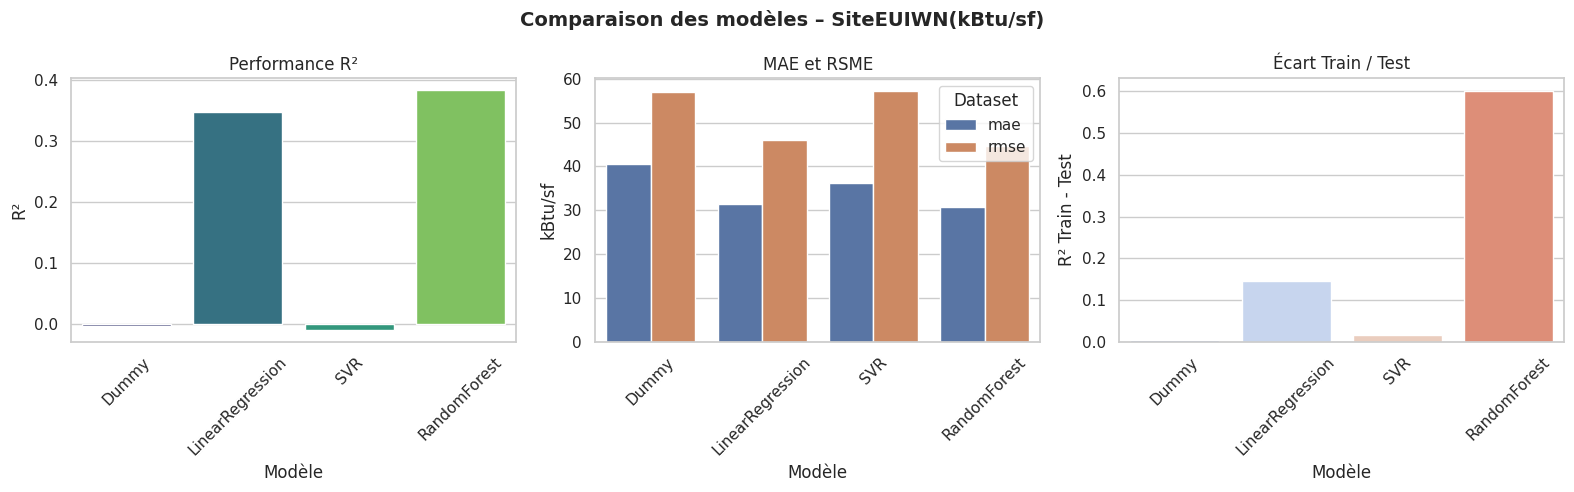

In [11]:
def display_results_models(results_list: List[dict], columns_to_show : List[str] = []):
    df = pd.DataFrame(results_list)
    display(df[columns_to_show].round(2))


def plot_model_comparison(results_all_models, suptitle):
    df_models = pd.DataFrame(results_all_models)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(
        suptitle,
        fontsize=14,
        fontweight="bold"
    )

    # R²
    plot_bar(
        df_models,
        x="model_name",
        y="r2",
        ax=axes[0],
        ylabel="R²",
        title="Performance R²",
        palette="viridis",
        xlabel="Modèle"
    )

    # MAE Train / Test
    plot_metric_comparison(
        df_models,
        id_col="model_name",
        metrics=["mae", "rmse"],
        value_name="kBtu/sf",
        ax=axes[1],
        title="MAE et RSME",
        xlabel="Modèle"
    )

    # Overfitting gap
    plot_bar(
        df_models,
        x="model_name",
        y="r2_train_test_gap",
        ax=axes[2],
        ylabel="R² Train - Test",
        title="Écart Train / Test",
        palette="coolwarm",
        xlabel="Modèle"
    )

    plt.tight_layout()
    plt.show()


print("Métriques de validation croisée")
display_results_models(results_all_models, ['model_name', 'r2_cv_train', 'r2_cv_test', 'mae_cv_test', 'rmse_cv_test', 'r2_train_test_gap', 'duration_cv'])
print("Métriques sur jeu de test final")
display_results_models(results_all_models, ['model_name', 'r2', 'mae', 'rmse', 'duration'])

plot_model_comparison(results_all_models, f"Comparaison des modèles – {TARGET_ENERGY}")

**Observations**

Les modèles Dummy et SVR obtiennent un R² proche de 0, ce qui signifie qu’ils ne parviennent pas à expliquer correctement la variable à prédire. Leurs prédictions sont donc peu fiables dans ce contexte. Pour SVR cela peut s'expliquer par les paramartre par défaut que ne sont pas adapté à ce jeu de données.

Le modèle RandomForest donne de meilleurs résultats que la régression linéaire. Il présente un R² légèrement plus élevé (0.38 contre 0.35) ainsi que des erreurs (MAE et RMSE) plus faibles, ce qui indique de meilleures performances de prédiction.

Cependant, le RandomForest apprend très bien sur les données d’entraînement mais moins bien sur les données de test. L’écart important entre les performances d’entraînement et de test met en évidence un surapprentissage : le modèle est trop adapté aux données d’entraînement et généralise mal sur de nouvelles données.

**Choix du modèle**

Nous choisissons le modèle RandomForest, car il offre les meilleures performances globales parmi les modèles testés. Une optimisation des hyperparamètres sera réalisée afin d’améliorer sa capacité de généralisation et de réduire le surapprentissage observé.

## Optimisation des hyperparamètres (GridSearchCV)

Afin d’améliorer les performances du modèle **RandomForest**, nous utilisons un **GridSearchCV** en ajustant plusieurs hyperparamètres clés. L’objectif principal est de **réduire le surapprentissage**, identifié lors de l’étape d’évaluation des modèles.

**GridSearchCV** est une fonction qui permet à la fois d'implémenter une validation croisée et de sélectionner les paramètres optimaux du modèle.

`n_estimators` — Nombre d'arbres
- Plus le nombre d'arbres est élevé, plus le modèle est stable
- Les prédictions sont moyennées, ce qui réduit la variance

`max_depth` — Profondeur maximale des arbres
- Limite la complexité de chaque arbre
- Empêche l'apprentissage de règles trop spécifiques aux données d'entraînement

`min_samples_split` — Minimum d'exemples pour diviser un nœud
- Empêche la création de splits basés sur trop peu d'observations
- Réduit les décisions instables ou peu représentatives

`min_samples_leaf` — Minimum d'exemples par feuille
- Force chaque prédiction finale à reposer sur un nombre suffisant d'exemples
- Améliore la stabilité et la capacité de généralisation du modèle

`max_features` — Nombre de features considérées pour chaque split
- Introduit de la randomisation en limitant les variables disponibles à chaque division
- 'sqrt' utilise la racine carrée du nombre total de features, 0.5 en utilise la moitié
- Réduit la corrélation entre les arbres et améliore la diversité de l'ensemble


In [12]:
def gridsearch_random_forest(X_train, y_train, kfold, param_grid):
    """
    Optimise les hyperparamètres d'un RandomForest via GridSearchCV.
    
    Retour
    ------
    dict avec structure standardisée + best_params et best_model
    """
    start = time.time()
    grid_rf = GridSearchCV(
        estimator=RandomForestRegressor(random_state=RANDOM_STATE),
        param_grid=param_grid,
        cv=kfold,
        scoring= {
            'r2': 'r2',
            'mae': 'neg_mean_absolute_error',
            'rmse': 'neg_root_mean_squared_error'
        },
        refit='r2',
        n_jobs=-1,
        return_train_score=True
    )

    grid_rf.fit(X_train, y_train)

    duration = time.time() - start

    best_idx = grid_rf.best_index_
    cv = grid_rf.cv_results_

    return {
        "best_model": grid_rf.best_estimator_,
        "best_params": grid_rf.best_params_,
        "best_cv_r2": grid_rf.best_score_,
        'r2_cv_train': cv['mean_train_r2'][best_idx],
        'r2_cv_test': cv['mean_test_r2'][best_idx],
        'r2_train_test_gap': (
            cv['mean_train_r2'][best_idx] - cv['mean_test_r2'][best_idx]
        ),

        'mae_cv_train': -cv['mean_train_mae'][best_idx],
        'mae_cv_test': -cv['mean_test_mae'][best_idx],

        'rmse_cv_train': -cv['mean_train_rmse'][best_idx],
        'rmse_cv_test': -cv['mean_test_rmse'][best_idx],
        'duration': duration
    }

In [13]:
param_grid_rf = {
    'n_estimators': [150, 200, 250],
    'max_depth': [10, 12, 18, 25],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 5, 8],
    'max_features': ['sqrt', 0.5, 0.7]
}


results_gridsearch = gridsearch_random_forest(
    X_train_preprocessed,
    y_train,
    kfold,
    param_grid_rf
)

results_val_best_model = evaluate_model_validation(results_gridsearch['best_model'], X_test_preprocessed, y_test, feature_names)



📊 RÉSULTATS FINAUX - MEILLEURS MODÈLES RANDOM FOREST
Métriques de validation croisée


,model_name,r2_cv_train,r2_cv_test,mae_cv_test,rmse_cv_test,r2_train_test_gap
0,RandomForest,0.90,0.30,29.70,42.16,0.60
1,RFR Optimisé,0.68,0.31,29.51,42.13,0.37


Métriques sur jeu de test final


,model_name,r2,mae,rmse
0,RandomForest,0.38,30.73,44.73
1,RFR Optimisé,0.40,30.74,44.27



🔧 MEILLEURS PARAMÈTRES PAR CIBLE

{'max_depth': 12, 'max_features': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 250}


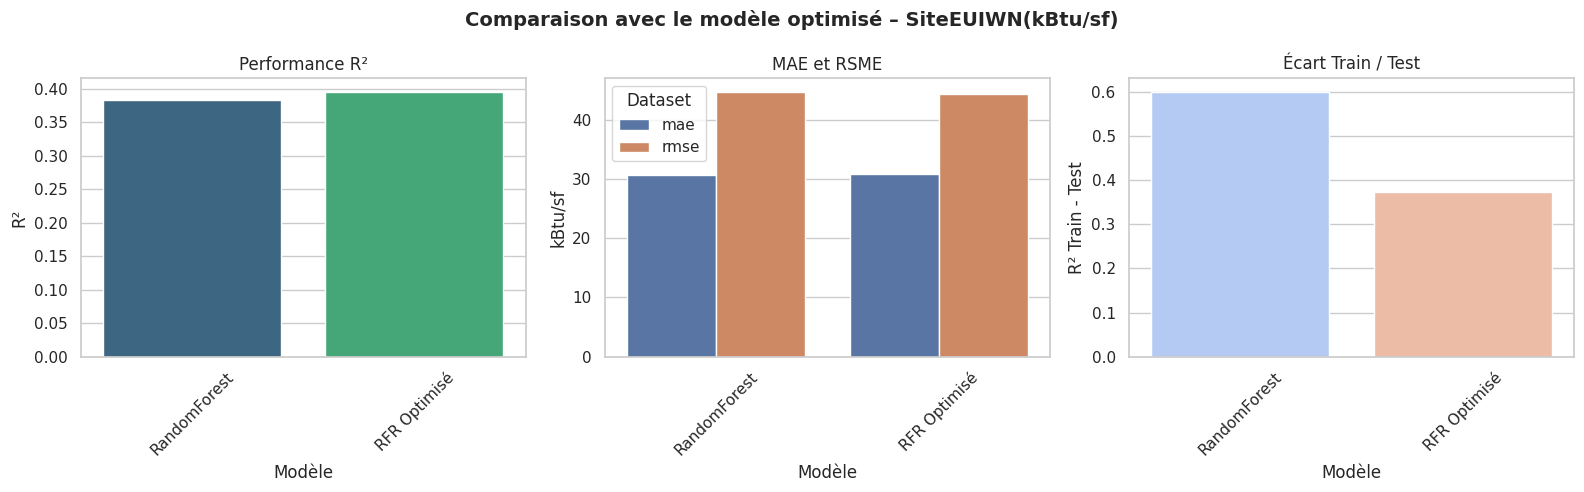

In [14]:
results_best_model = {
    'model_name': "RFR Optimisé",
    **results_val_best_model,
    **results_gridsearch
}

rf_avant = next(
    r for r in results_all_models
    if r["model_name"] == "RandomForest"
)

print("\n" + "="*80)
print("📊 RÉSULTATS FINAUX - MEILLEURS MODÈLES RANDOM FOREST")
print("="*80)

print("Métriques de validation croisée")
display_results_models([rf_avant, results_best_model], ['model_name', 'r2_cv_train', 'r2_cv_test', 'mae_cv_test', 'rmse_cv_test', 'r2_train_test_gap'])
print("Métriques sur jeu de test final")
display_results_models([rf_avant, results_best_model], ['model_name', 'r2', 'mae', 'rmse'])
print("\n🔧 MEILLEURS PARAMÈTRES PAR CIBLE\n")
print(results_best_model['best_params'])

plot_model_comparison([rf_avant, results_best_model], f"Comparaison avec le modèle optimisé – {TARGET_ENERGY}")

**Observations**

L'optimisation des hyperparamètres a permis d'améliorer la capacité de généralisation du modèle :

| Métrique | Avant optimisation | Après optimisation | Évolution |
|----------|-------------------|-------------------|-----------|
| R² (test) | 0.38 | 0.40 | +5% |
| R² (train CV) | 0.90 | 0.68 | -24% |
| Gap train/test | 0.60 | 0.37 | -38% |

**Analyse du compromis biais-variance :**
- Le R² d'entraînement a baissé de 0.90 à 0.68, ce qui est **souhaitable** : le modèle mémorise moins les données d'entraînement
- Le gap train/test a été réduit de 0.60 à 0.37, indiquant une **meilleure généralisation**
- Le R² sur le jeu de test a légèrement augmenté (0.38 → 0.40), confirmant l'amélioration

**Paramètres optimaux retenus :**
- `max_depth=12` : limite la profondeur des arbres pour éviter les règles trop spécifiques
- `min_samples_leaf=3` et `min_samples_split=5` : impose un minimum d'observations par nœud
- `max_features=0.7` : introduit de la diversité entre les arbres
- `n_estimators=250` : nombre d'arbres suffisant pour stabiliser les prédictions

Le modèle optimisé présente un meilleur équilibre entre apprentissage et généralisation.


## Evaluation avec le jeu de donnée de validation

Le jeu de validation provient du **split initial réalisé dans le notebook 1** :
- Split stratifié 80/20 effectué **avant** tout prétraitement
- 80% → entraînement et test (ce notebook)
- 20% → validation finale (fichier `data_val_clean_with_energystart.csv`)

Ce jeu n'a **jamais été utilisé** durant la phase d'entraînement ou d'optimisation des hyperparamètres. Il permet d'évaluer la capacité de généralisation réelle du modèle sur des données totalement inédites.

Le même pipeline de nettoyage et de feature engineering a été appliqué aux deux jeux de données pour garantir la cohérence.

In [15]:
# Charger les données de validation
data_val = pd.read_csv('data/data_val_clean.csv')  # Adaptez le chemin

# Séparer les features et les cibles
X_val, y_val = split_features_targets(data_val, CIBLES + ['ENERGYSTARScore'], TARGET_ENERGY)

X_val_preprocessed  = preprocessor.transform(X_val)

results_validation = {}

results_validation = evaluate_model_validation(results_best_model['best_model'], X_val_preprocessed , y_val, feature_names)

results_validation = {
	'model_name' : "RFR Optimisé (data validation)",
	**results_validation
}


,model_name,r2,mae,rmse
0,RFR Optimisé,0.40,30.74,44.27
1,RFR Optimisé (data validation),0.49,23.13,31.85


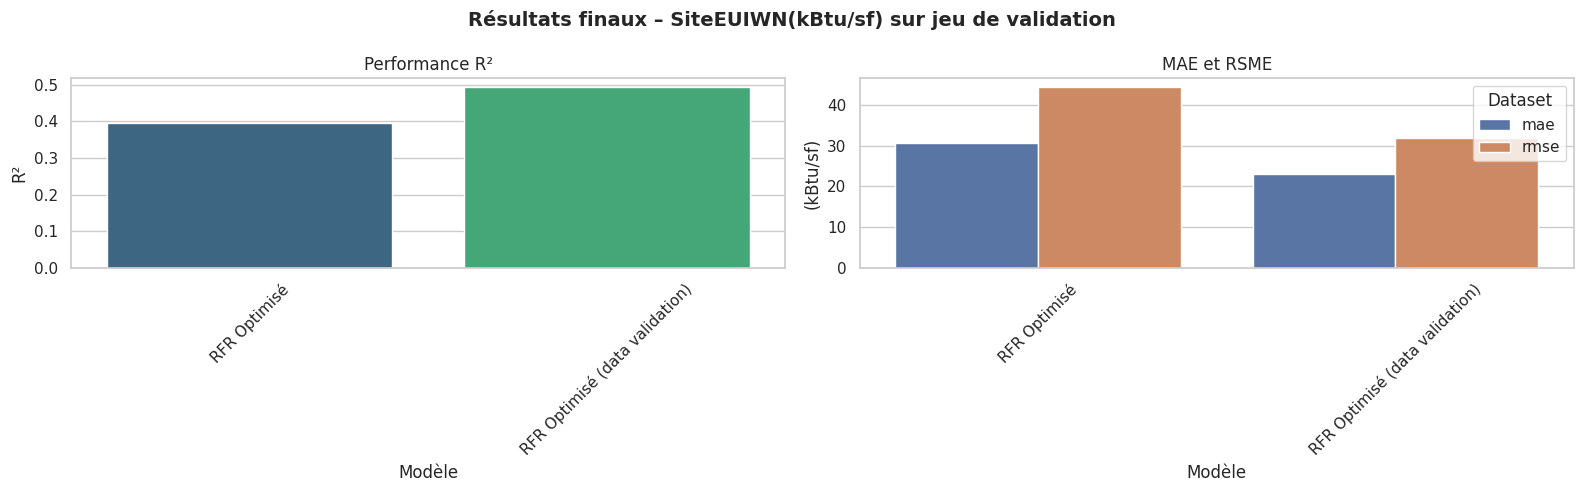

In [16]:
display_results_models([results_best_model, results_validation], ['model_name', 'r2', 'mae', 'rmse'])

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle(
    f"Résultats finaux – {TARGET_ENERGY} sur jeu de validation",
    fontsize=14,
    fontweight="bold"
)

# R²
plot_bar(
    pd.DataFrame([results_best_model, results_validation]),
    x="model_name",
    y="r2",
    ax=axes[0],
    ylabel="R²",
	xlabel="Modèle",
    title="Performance R²",
    palette="viridis"
)

# MAE Train / Test
plot_metric_comparison(
    pd.DataFrame([results_best_model, results_validation]),
    id_col="model_name",
    metrics=["mae", "rmse"],
    value_name="(kBtu/sf)",
    ax=axes[1],
    title="MAE et RSME",
	xlabel="Modèle",
)

plt.tight_layout()
plt.show()

**Observation**

Les performances sur le jeu de validation finale sont supérieures à celles observées sur le jeu de test :

| Jeu de données | R² | MAE | RMSE |
|----------------|-----|-----|------|
| Test (20% train) | 0.40 | 30.74 | 44.27 |
| Validation finale | 0.49 | 23.13 | 31.85 |

**Interprétation :**

Cette différence peut s'expliquer par plusieurs facteurs :
1. **Variabilité des échantillons** : avec des jeux de données de taille modeste, les performances peuvent varier selon la composition de l'échantillon
2. **Distribution des données** : le jeu de validation peut contenir des bâtiments avec des caractéristiques plus homogènes ou plus proches des patterns appris
3. **Absence de valeurs extrêmes** : le RMSE nettement plus faible (31.85 vs 44.27) suggère moins d'erreurs importantes sur ce jeu

**Conclusion :** Le modèle généralise correctement sur des données totalement inédites, avec environ 49% de la variance expliquée.




🔝 Top 15 features (agrégées) - SiteEUIWN(kBtu/sf)


,original_feature,importance_mean,importance_std
4,PrimaryPropertyType,9.977548,0.845908
7,electricity_share,4.442918,0.421297
11,has_laboratory,0.964907,0.253872
5,building_age,0.666378,0.241818
20,parking_ratio,0.514142,0.114776
3,NumberofFloors,0.158635,0.128980
6,decade_built,0.156570,0.102903
1,Neighborhood,0.144654,0.091201
14,has_restaurant,0.141167,0.044320
12,has_medical,0.107363,0.048283


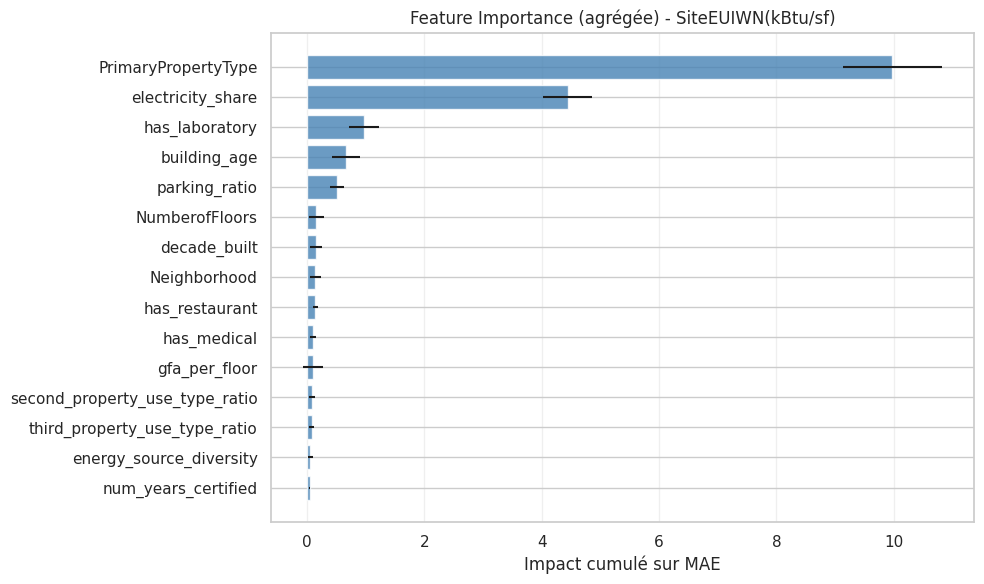

In [17]:
def display_aggregated_features(importance_df, target_name, categorical_features, top_n=10):
    """
    Affiche les features importantes :
    - Noms nettoyés (sans num__, cat__)
    - Variables catégorielles agrégées
    """
    
    # 1. Nettoyer
    df = importance_df.copy()
    df['feature'] = [name.split('__', 1)[-1] for name in df['feature']]

    
    # 2. Agréger
    original_features = []
    for col in df['feature']:
        matched = False
        for cat in categorical_features:
            if col.startswith(cat + "_"):
                original_features.append(cat)
                matched = True
                break
        if not matched:
            original_features.append(col)
    
    df['original_feature'] = original_features
    
    # 3. Grouper
    aggregated = (
        df
        .groupby('original_feature', as_index=False)
        .agg({
            'importance_mean': 'sum',
            'importance_std': lambda x: np.sqrt(np.sum(x**2))
        })
        .sort_values('importance_mean', ascending=False)
        .head(top_n)
    )
    
    # 4. Affichage
    print("\n" + "="*70)
    print(f"🔝 Top {top_n} features (agrégées) - {target_name}")
    print("="*70)
    display(aggregated)
    
    # 5. Graphique
    plt.figure(figsize=(10, 6))
    plt.barh(
        range(len(aggregated)),
        aggregated['importance_mean'].values[::-1],
        xerr=aggregated['importance_std'].values[::-1],
        alpha=0.8,
        color='steelblue'
    )
    plt.yticks(range(len(aggregated)), aggregated['original_feature'].values[::-1])
    plt.xlabel('Impact cumulé sur MAE')
    plt.title(f'Feature Importance (agrégée) - {target_name}')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

display_aggregated_features(results_validation['importance_df'], TARGET_ENERGY, X_categorical, top_n=15)

#### Variables les plus importantes
- **Type d’usage du bâtiment**
- **Présence de données EnergyStar**

Ces deux éléments expliquent l’essentiel de la consommation énergétique. En clair, **ce à quoi sert le bâtiment** et **la qualité des données disponibles** sont les facteurs clés.

#### Variables d’importance moyenne
- Part de l’électricité et du gaz
- Surface moyenne par étage
- Âge du bâtiment
- Nombre d’étages

Ces variables améliorent la prédiction, mais leur effet reste limité par rapport à l’usage du bâtiment.

#### Variables peu importantes
- Localisation précise
- Mixité des usages
- Indicateurs liés au stationnement ou aux usages secondaires

Leur faible impact montre que **les grandes caractéristiques du bâtiment comptent plus que les détails locaux**.

#### Interprétation générale
La consommation énergétique des bâtiments non résidentiels dépend avant tout **de leur fonction et de leur mode d’exploitation**, et beaucoup moins de leur emplacement ou de caractéristiques secondaires.  
Cela explique pourquoi le modèle a des performances correctes mais limitées sur cette cible.


## Analyse de l'impact de ENERGYSTARScore


In [18]:
df_with_energystar = df_origin.copy()
df_with_energystar = df_with_energystar[df_with_energystar['ENERGYSTARScore'].notna()]
print(f"df_with_energystar : {df_with_energystar.shape}")


df_with_energystar : (744, 28)


Nous conservons uniquement les lignes avec une valeur non nulle pour ENERGYSTARScore, ce qui fait passer le dataset de 1 151 à 744 observations.

In [19]:
X_with_energystar, y_with_energystar = split_features_targets(df_with_energystar, CIBLES , TARGET_ENERGY)

X_categorical_with_es, X_numeric_with_es = identify_feature_types(X_with_energystar)

preprocessor_with_es = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_numeric_with_es),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_categorical_with_es)
    ]
)

In [20]:
results_with_es = []

X_train_es, X_test_es, y_train_es, y_test_es = train_test_split(
    X_with_energystar,
    y_with_energystar,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# Transformer les données
X_train_es_preprocessed = preprocessor_with_es.fit_transform(X_train_es)
X_test_es_preprocessed = preprocessor_with_es.transform(X_test_es)

feature_names_es = preprocessor_with_es.get_feature_names_out()
model_rf = RandomForestRegressor(**results_best_model['best_params'], random_state=RANDOM_STATE)
results_cv_with_es = train_and_evaluate_model_cv(model_rf, X_train_es_preprocessed, y_train_es, kfold)
results_val_with_es = evaluate_model_validation(results_cv_with_es['model_fitted'], X_test_es_preprocessed, y_test_es, feature_names_es)
results_es = {
	'model_name' : "RFR avec ENERGYSTARScore",
	**results_val_with_es,
	**results_cv_with_es
}

Métriques de validation croisée


,model_name,r2_cv_train,r2_cv_test,mae_cv_test,rmse_cv_test,r2_train_test_gap
0,RandomForest,0.90,0.30,29.70,42.16,0.60
1,RFR Optimisé,0.68,0.31,29.51,42.13,0.37
2,RFR avec ENERGYSTARScore,0.84,0.59,18.10,29.04,0.25


Métriques sur jeu de test final


,model_name,r2,mae,rmse
0,RandomForest,0.38,30.73,44.73
1,RFR Optimisé,0.40,30.74,44.27
2,RFR avec ENERGYSTARScore,0.69,17.71,26.96


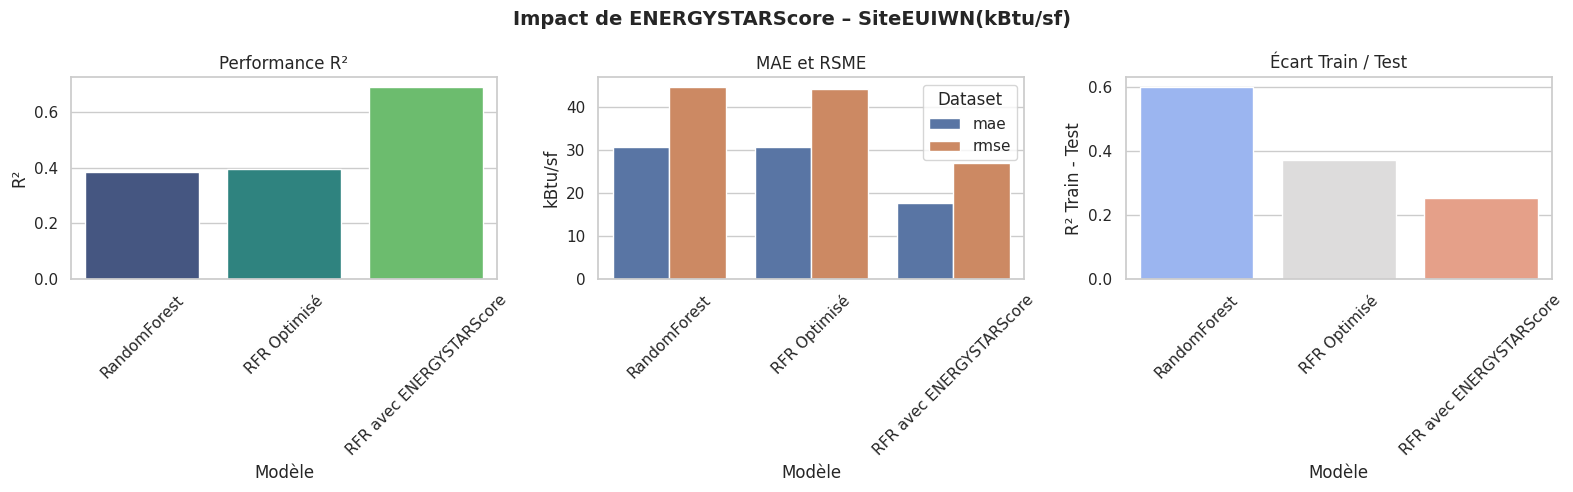

In [21]:
print("Métriques de validation croisée")
display_results_models([rf_avant, results_best_model, results_es], ['model_name', 'r2_cv_train', 'r2_cv_test', 'mae_cv_test', 'rmse_cv_test', 'r2_train_test_gap'])
print("Métriques sur jeu de test final")
display_results_models([rf_avant, results_best_model, results_es], ['model_name', 'r2', 'mae', 'rmse'])

plot_model_comparison([rf_avant, results_best_model, results_es], f"Impact de ENERGYSTARScore – {TARGET_ENERGY}")

**Interprétation :**

L'ajout de la variable `ENERGYSTARScore` améliore considérablement les performances du modèle :

| Modèle | R² | MAE | RMSE | Gap train/test |
|--------|-----|-----|------|----------------|
| RFR Optimisé (sans ES) | 0.40 | 30.74 | 44.27 | 0.37 |
| RFR avec ENERGYSTARScore | 0.69 | 17.71 | 26.96 | 0.25 |

**Analyse des résultats :**

1. **Amélioration spectaculaire** : le R² passe de 0.40 à 0.69, soit +72% de variance expliquée
2. **Réduction des erreurs** : la MAE diminue de 42% (30.74 → 17.71 kBtu/sf) et le RMSE est passer de 44.27 -> 26.96 kBtu/sf)
3. **Meilleure généralisation** : le gap train/test passe de 0.37 à 0.25

## Conclusion et recommandations

### Résumé des résultats

Le **Random Forest optimisé** est le modèle le plus performant :

- Sans **ENERGYSTARScore**, il explique environ **40 à 49 %** de la consommation énergétique.
- Avec **ENERGYSTARScore**, les performances augmentent fortement (**R² = 0.69**), montrant l’importance de cette variable.

### Variables les plus importantes

La consommation énergétique des bâtiments dépend principalement de :

- **Le type de bâtiment** (usage principal)
- **La présence d’un score ENERGY STAR**
- **Le type d’énergie utilisée** (électricité, gaz)
- **Les caractéristiques du bâtiment** (surface, âge, nombre d’étages)

La localisation géographique a un impact limité.

### Limites du modèle

- Performances limitées sans **ENERGYSTARScore**
- **35 %** des bâtiments ne disposent pas de ce score
- Résultats variables selon les échantillons

### Recommandations

**Pour améliorer le modèle :**
- Tester des modèles plus avancés (Gradient Boosting, XGBoost)
- Ajouter des données externes (météo, occupation, équipement)

**Pour l’utilisation :**
- Utiliser le modèle avec **ENERGYSTARScore** lorsqu’il est disponible
- Utiliser le modèle standard dans les autres cas

### Conclusion générale

Le modèle permet d’identifier les principaux facteurs de consommation énergétique des bâtiments à Seattle.  
Il constitue une base solide pour cibler les bâtiments énergivores et soutenir l’objectif de **neutralité carbone à l’horizon 2050**.

La prédiction des émissions de CO₂ sera traitée dans un notebook séparé.



